In [1]:
%config IPCompleter.greedy=True
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
from dateutil.parser import parse as parse_date
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spotipy
import spotipy.util as util
import pyplot_themes as themes

## Recent top songs

In [3]:
user_id = '6sv95ub14tdhriy0zglf28t6a'
client_id='8e9d4b3d23914cd095065e4f47591e0a'
client_secret='1673f4fe2ae8422a8f3548d1a1f6ad0c'

In [4]:
token = util.prompt_for_user_token(user_id,
                                 'user-top-read playlist-read-collaborative', 
                                   client_id=client_id,
                                   client_secret=client_secret,
                                  redirect_uri='http://mysite.com/callback/fav')
if token:
    sp = spotipy.Spotify(auth=token)

### Recent top tracks

In [6]:
if token:
    sp = spotipy.Spotify(auth=token)
    artist_shortterm = []
    song_shortterm = []
    results = sp.current_user_top_tracks(time_range='short_term', limit=50)
    for i, item in enumerate(results['items']):
        song_shortterm.append(item['name'])
        artist_shortterm.append(item['artists'][0]['name'])
pd_top50 = pd.DataFrame({'track':song_shortterm, 
        'artist':artist_shortterm })
#pd_top50 = pd_top50.sort_values(by='artist')
pd_top50.sample(10)
#pd_top50

,track,artist
1,Waiting Room,Fugazi
28,Mr. Grieves,Pixies
15,Friday I'm in Love,The Cure
6,Just Like Honey,The Jesus and Mary Chain
45,On Graveyard Hill,Pixies
37,"Hey, Ma",Bon Iver
8,Teen Age Riot (Live),Sonic Youth
38,Plastic Panorama,Postiljonen
18,Um Chagga Lagga,Pixies
40,Do You Like Me,Fugazi


###  Recent top artists

In [7]:
if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False
    artist_shortterm = []
    top_artist = sp.current_user_top_artists(time_range='short_term', limit=50)
    for i, item in enumerate(top_artist['items']):
        artist_shortterm.append(item['name'])
    pd_artists = pd.DataFrame({'artist':artist_shortterm})
pd_artists

,artist
0,Pixies
1,Sonic Youth
2,Fugazi
3,Sublime
4,Oasis
5,Glass Animals
6,The Velvet Underground
7,Talking Heads
8,Guns N' Roses
9,The Jesus and Mary Chain


In [9]:
if token:
    results = sp.current_user_top_tracks(limit=50, offset=0,time_range='short_term')
list_of_results = results["items"]
list_of_artist_names = []
list_of_song_names = []
list_of_albums = []
list_of_popularity = []

for result in list_of_results:
    #result["album"]
    this_artists_name = result["artists"][0]["name"]
    list_of_artist_names.append(this_artists_name)
    list_of_songs = result["name"]
    list_of_song_names.append(list_of_songs)
    this_album = result["album"]["name"]
    list_of_albums.append(this_album)
    song_popularity = result["popularity"]
    list_of_popularity.append(song_popularity)
    
top50 = pd.DataFrame(
    {'artist': list_of_artist_names,
     'song': list_of_song_names,
     'album': list_of_albums,
     'popularity': list_of_popularity
    })

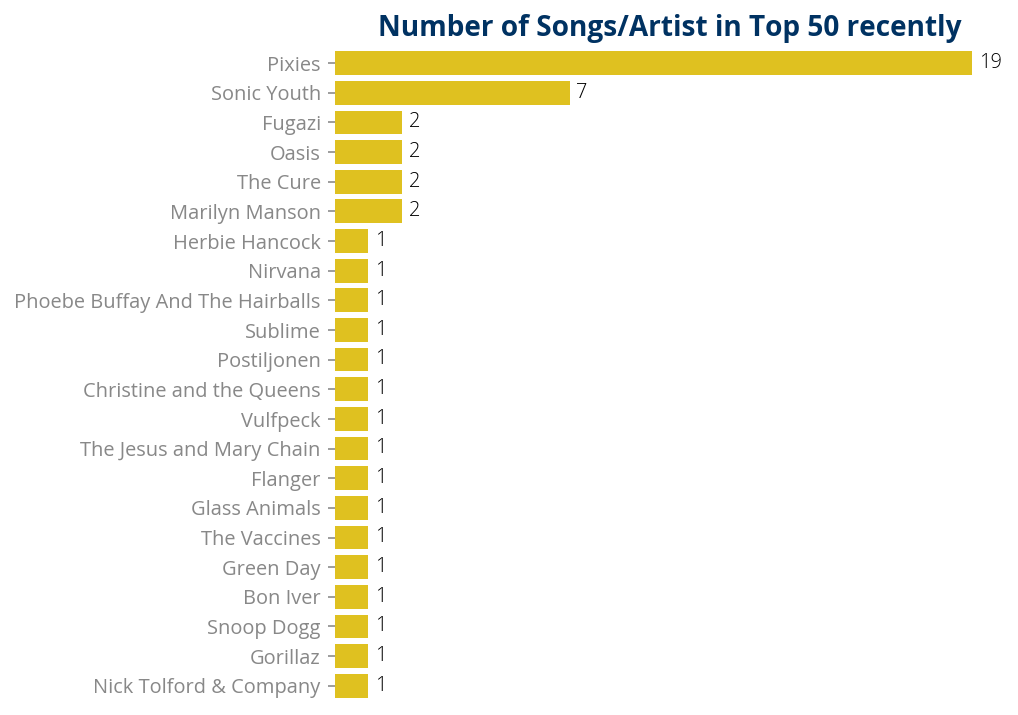

In [10]:
themes.theme_ucberkeley(figsize=[6,6])

descending_order = top50['artist'].value_counts().sort_values(ascending=False).index

ax = sns.countplot(y = top50['artist'], order=descending_order, color='#ffd700')
#sns.despine(fig=None, ax=None, top=True, right=True, left=False, trim=False)
ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_title('Number of Songs/Artist in Top 50 recently', fontsize=14, fontweight='heavy')
ax.axes.get_xaxis().set_visible(False)
ax.set_frame_on(False)

y = top50['artist'].value_counts()
for i, v in enumerate(y):
    ax.text(v + 0.2, i + .16, str(v), color='black', fontweight='light', fontsize=10)

## Look into a playlist 

In [11]:
user_playlists = sp.user_playlists(user=user_id)

for playlist in user_playlists['items']:
    print(playlist['id'], playlist['name'])

6BgM0WE6GXv2HLXYj1D4lu TUNE
37i9dQZF1E4zM8lwNVTMQI Sonic Youth Radio
42PZihHa5JlJOqfNjd470c Driving
3NVmRhOFS8OATMTRHP6mUB Kick
21BwKkjfxTc1AKYTl7QxkL wedding
5y7VC5N6v4M8ZqeN7SWTvK Detached
6sRetqhCIdjFqh1AONjCF2 From Movies


In [12]:
playlist = sp.user_playlist(user_id, '6BgM0WE6GXv2HLXYj1D4lu')
tracks = playlist['tracks']['items']
next_uri = playlist['tracks']['next']
for _ in range(int(playlist['tracks']['total'] / playlist['tracks']['limit'])):
    response = sp._get(next_uri)
    tracks += response['items']
    next_uri = response['next']

In [13]:
tracks_df = pd.DataFrame([(track['track']['id'],
                           track['track']['artists'][0]['name'],
                           track['track']['name'],
                           parse_date(track['track']['album']['release_date']) if track['track']['album']['release_date'] else None,
                           parse_date(track['added_at']))
                          for track in playlist['tracks']['items']],
                         columns=['id', 'artist', 'name', 'release_date', 'added_at'] )

In [14]:
tracks_df['added_at'] = pd.to_datetime(tracks_df['added_at'])
tracks_df['release_date'] = pd.to_datetime(tracks_df['release_date'])

### Top artists

In [15]:
tracks_df.groupby('artist').count()['id'].reset_index().sort_values('id', ascending=False) \
    .rename(columns={'id': 'amount'}).head(10)

,artist,amount
277,Sublime,20
68,Dire Straits,18
301,The Cure,13
15,BANKS,12
237,Radiohead,11
227,Pink Floyd,11
211,Oasis,11
79,Eminem,11
202,Nirvana,11
100,Gorillaz,11


### Top artists by year

In [30]:
tracks_df \
    .assign(year_added=tracks_df.added_at.dt.year) \
    .groupby(['artist', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False) \
    .pivot('artist', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2019,2020
artist,,
2Pac,1.000000,0.000000
311,0.000000,3.000000
88rising,1.000000,4.000000
A Tribe Called Quest,0.000000,1.000000
AC/DC,0.000000,7.000000
Aerosmith,1.000000,2.000000
Against Me!,0.000000,2.000000
Alex Turner,1.000000,3.000000
Alice Cooper,0.000000,1.000000


In [31]:
counted_year_df = tracks_df \
    .assign(year_added=tracks_df.added_at.dt.year) \
    .groupby(['artist', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False)

in_top_5_year_artist = counted_year_df \
    .groupby('year_added') \
    .head(5) \
    .artist \
    .unique()

counted_year_df \
    [counted_year_df.artist.isin(in_top_5_year_artist)] \
    .pivot('artist', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2019,2020
artist,,
BANKS,7.000000,5.000000
Cage The Elephant,0.000000,11.000000
Dire Straits,7.000000,11.000000
Glass Animals,8.000000,2.000000
Gorillaz,7.000000,4.000000
Oasis,1.000000,10.000000
Pulp,6.000000,1.000000
Sublime,0.000000,20.000000
The Cure,1.000000,12.000000


### Release date per year

In [37]:
tracks_df \
    .assign(year_added=tracks_df.added_at.dt.year,
            year_released=tracks_df.release_date.dt.year) \
    .groupby(['year_released', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False) \
    .pivot('year_released', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2019,2020
year_released,,
1964,0.000000,1.000000
1965,1.000000,8.000000
1966,0.000000,3.000000
1967,1.000000,7.000000
1968,0.000000,1.000000
1969,0.000000,6.000000
1970,0.000000,4.000000
1971,2.000000,3.000000
1972,2.000000,0.000000


In [38]:
counted_release_year_df = tracks_df \
    .assign(year_added=tracks_df.added_at.dt.year,
            year_released=tracks_df.release_date.dt.year) \
    .groupby(['year_released', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False)

in_top_5_year_released = counted_release_year_df \
    .groupby('year_added') \
    .head(5) \
    .year_released \
    .unique()

counted_release_year_df \
    [counted_release_year_df.year_released.isin(in_top_5_year_released)] \
    .pivot('year_released', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2019,2020
year_released,,
2008,10.000000,8.000000
2014,15.000000,12.000000
2016,11.000000,29.000000
2017,17.000000,43.000000
2018,13.000000,26.000000
2019,4.000000,38.000000
2020,0.000000,61.000000


## Audio features

In [16]:
def get_features_from_playlist(user='', playlist_id=''):
    '''
    Takes in a user_id and a playlist_id and returns a dataframe of a user's playlist songs
    '''
    df_result = pd.DataFrame()
    track_list = ''
    uploader_list = []
    added_ts_list = []
    artist_list = []
    title_list = []
    release_date =[]

    more_songs = True #As long as there is tracks not fetched from API, continue looping
    offset_index = 0
    
    if playlist_id != '' and user == '':
        print("Enter username for playlist")
        return

    while more_songs:
        songs = sp.user_playlist_tracks(user, playlist_id=playlist_id, offset=offset_index)

        for song in songs['items']:
            #join track ids to a single string as an input parameter for audio_features function
            track_list += song['track']['id'] +','

            #get the time when the song was added
            added_ts_list.append(song['added_at'])

            #get the title of the song
            title_list.append(song['track']['name'])
            
            #get all the artists in the song
            artists = song['track']['artists']
            artists_name = ''
            for artist in artists:
                artists_name += artist['name']  + ','
            artist_list.append(artists_name[:-1])
            
            #get user who added song in the playlist, catering for collaboration playlists
            uploader_list.append(song['added_by']['id'])
            
            # get release date of the album
            release_date.append(song['track']['album']['release_date'])

        #get the track features and append into a dataframe
        track_features = sp.audio_features(track_list[:-1])
        df_temp = pd.DataFrame(track_features)
        df_result = df_result.append(df_temp)
        track_list = ''

        if songs['next'] == None:
            # no more songs in playlist
            more_songs = False
        else:
            # get the next n songs
            offset_index += songs['limit']
            print('Progress: ' + str(offset_index) + ' of '+ str(songs['total']))

    #add the timestamp added, title and artists of a song
    df_result['added_at'], df_result['song_title'], df_result['artists'] = added_ts_list, title_list, artist_list
    
        
    print('--- COMPLETED ---')
    
    return df_result    

In [17]:
tracks_w_features = get_features_from_playlist(user='6sv95ub14tdhriy0zglf28t6a', 
                                       playlist_id='6BgM0WE6GXv2HLXYj1D4lu')

Progress: 100 of 848
Progress: 200 of 848
Progress: 300 of 848
Progress: 400 of 848
Progress: 500 of 848
Progress: 600 of 848
Progress: 700 of 848
Progress: 800 of 848
--- COMPLETED ---


In [18]:
tracks_w_features = tracks_w_features[['id', 'artists', 'song_title', 'added_at', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature']]

In [19]:
tracks_w_features['added_at'] = pd.to_datetime(tracks_w_features['added_at'])

In [20]:
df_2020 = tracks_w_features.loc[tracks_w_features['added_at'].dt.year>=2020, ]

In [21]:
tracks_w_features.head()

,id,artists,song_title,added_at,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,5a4MgIUSf9K8wXLSm6xPEx,Pink Floyd,High Hopes,2019-09-21 18:38:25+00:00,0.520,0.411,0,-12.536,0,0.0250,0.2020,0.153000,0.3510,0.280,75.235,510965,4
1,7u8yddev0YnNFGkZoP8X2t,Blur,To the End - 2012 Remaster,2019-09-21 18:38:26+00:00,0.524,0.634,2,-8.968,1,0.0249,0.0166,0.000068,0.0895,0.634,96.289,244600,4
2,5g19EQEmBkiFuyTztsFjMU,Stereophonics,Indian Summer,2019-09-21 18:38:26+00:00,0.668,0.695,0,-4.961,1,0.0283,0.4050,0.000000,0.4270,0.809,105.926,267120,4
3,7jY2puQFxonAToK9HSnIuo,The London Suede,He's Gone,2019-09-21 18:38:26+00:00,0.211,0.692,7,-8.603,1,0.0416,0.0210,0.352000,0.6090,0.225,205.757,332753,4
4,2DPiTxkAJppAZ32M3jm6CZ,Brett Anderson,Back to You,2019-09-21 18:38:27+00:00,0.474,0.330,8,-8.127,0,0.0293,0.9360,0.000151,0.0984,0.293,125.913,194187,4


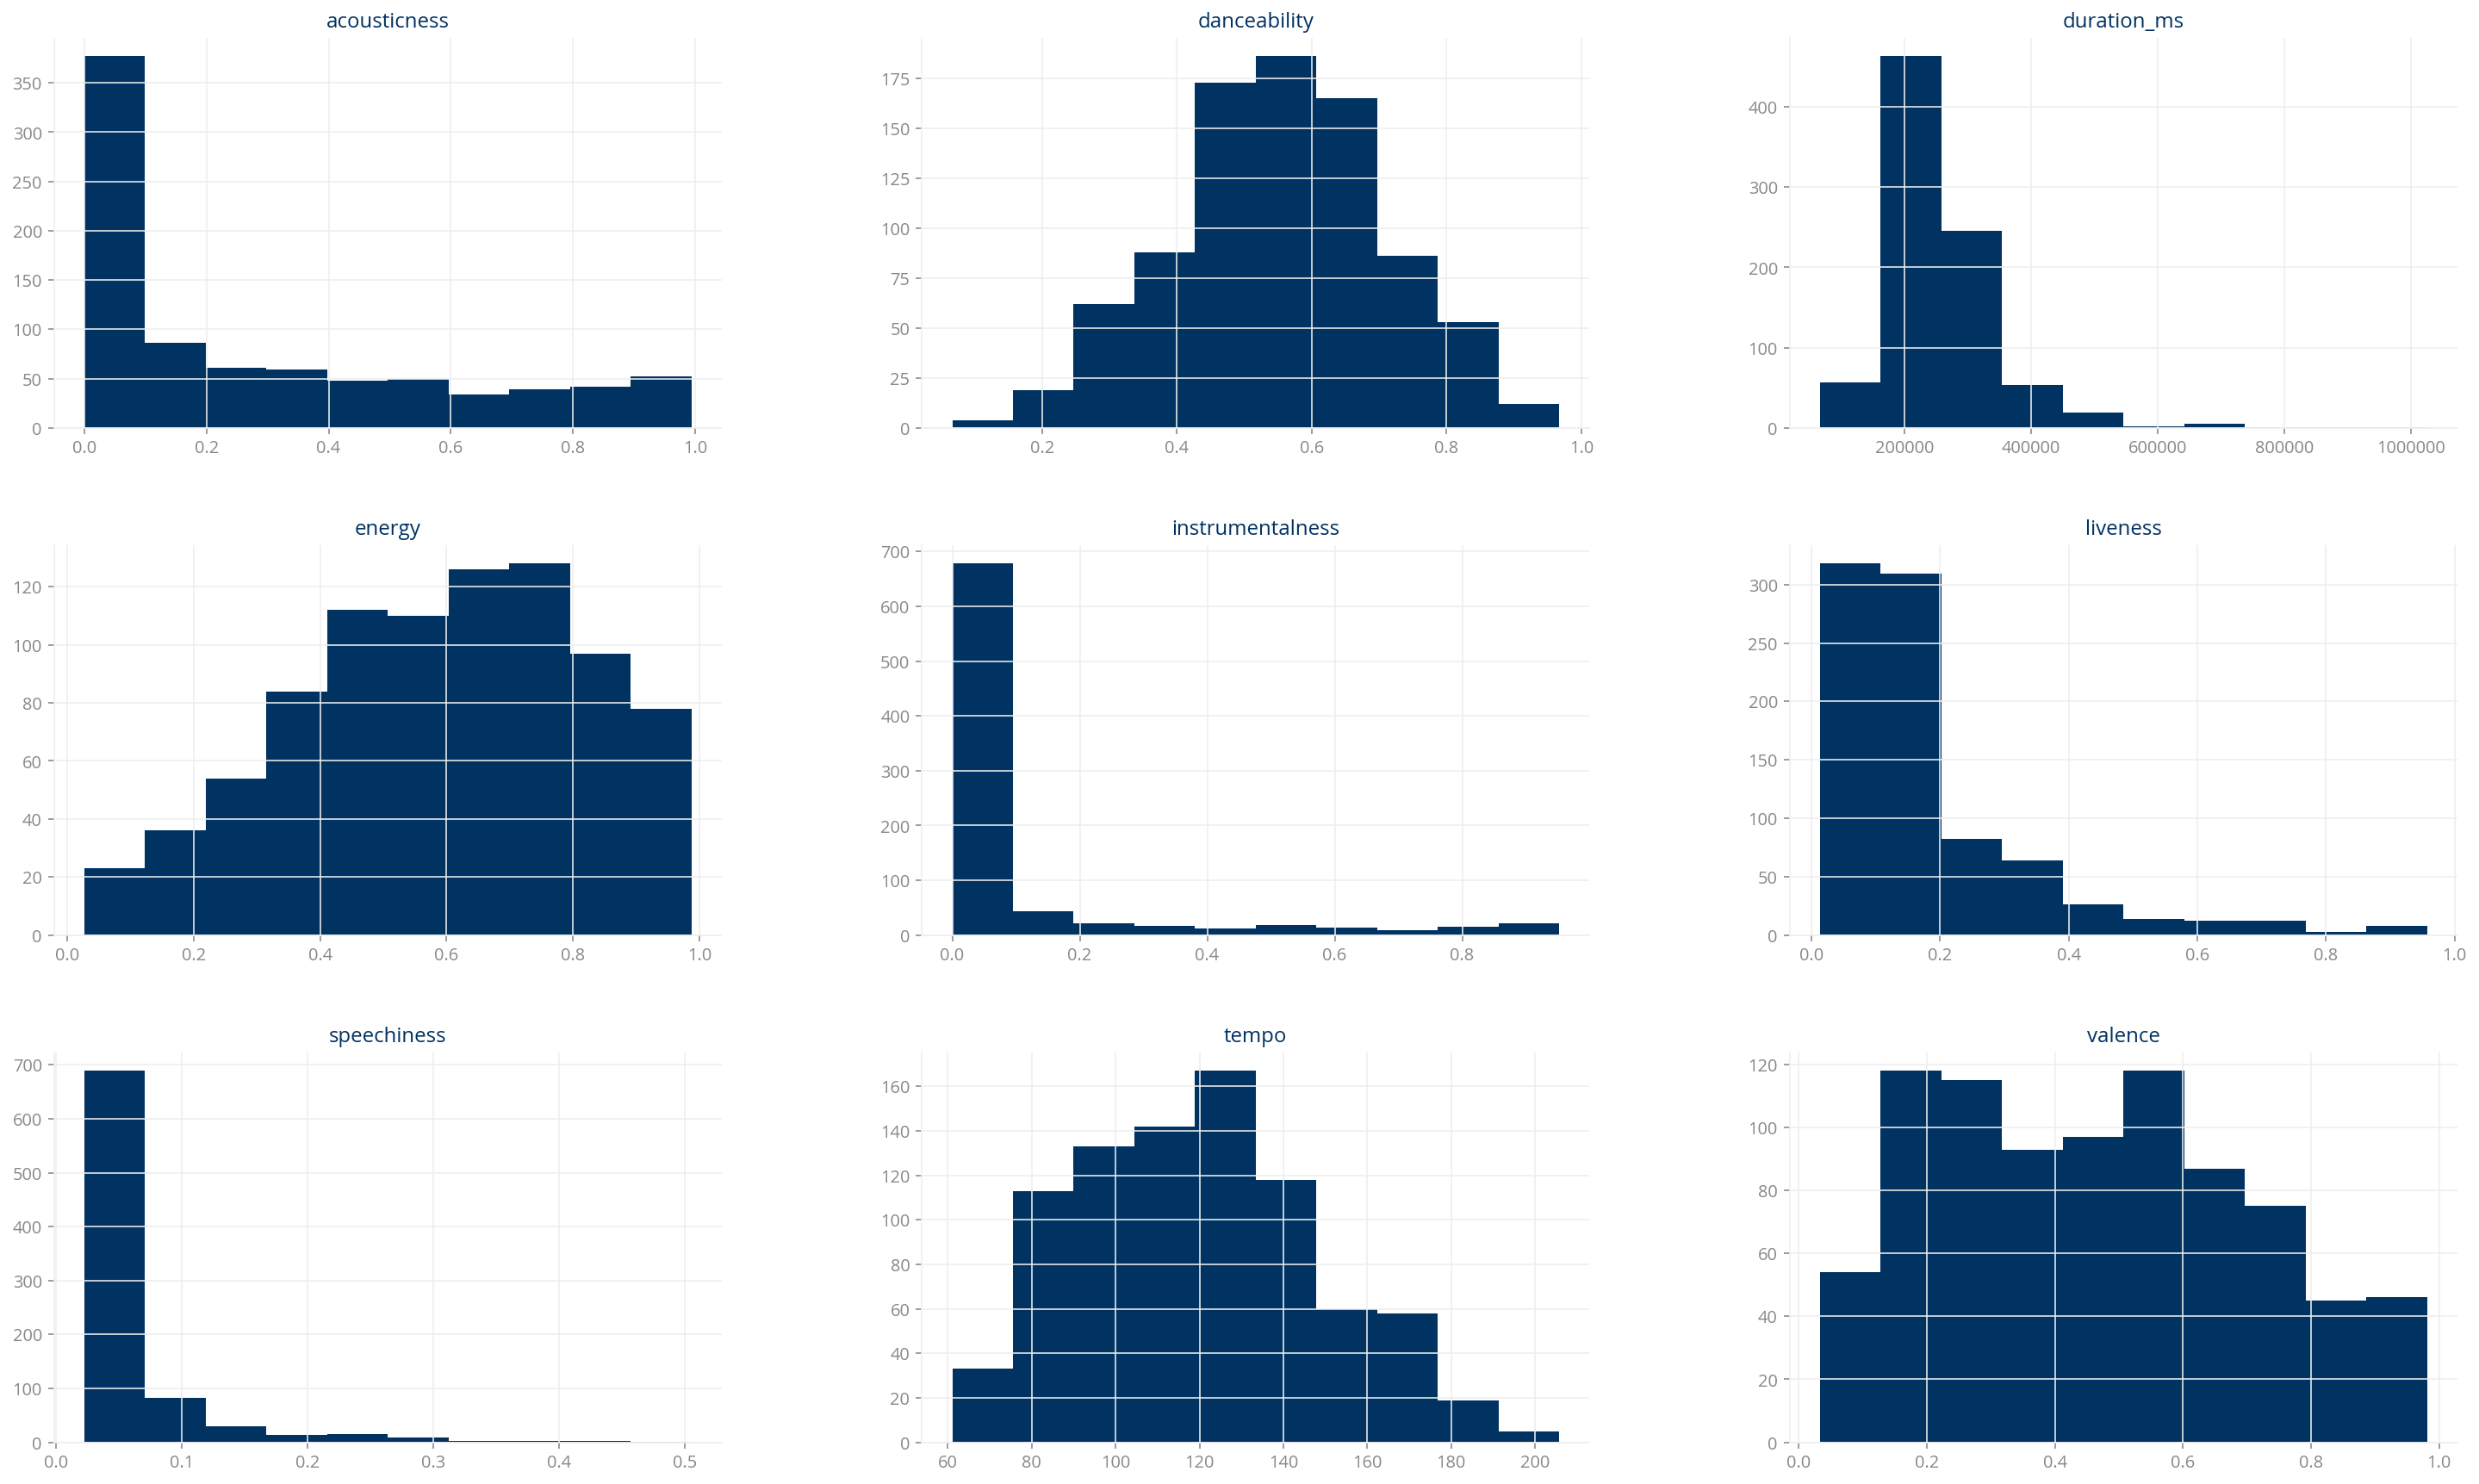

In [22]:
themes.theme_ucberkeley()
tracks_w_features[['acousticness', 'danceability', 'instrumentalness', 
           'energy', 'speechiness','tempo','valence','duration_ms',
           'liveness']].hist(figsize=(25,15))
plt.show()

### Danceability

In [47]:
df_2020 = df_2020[df_2020['danceability']>0.1]
df_2020 = df_2020[df_2020['danceability']<0.88]

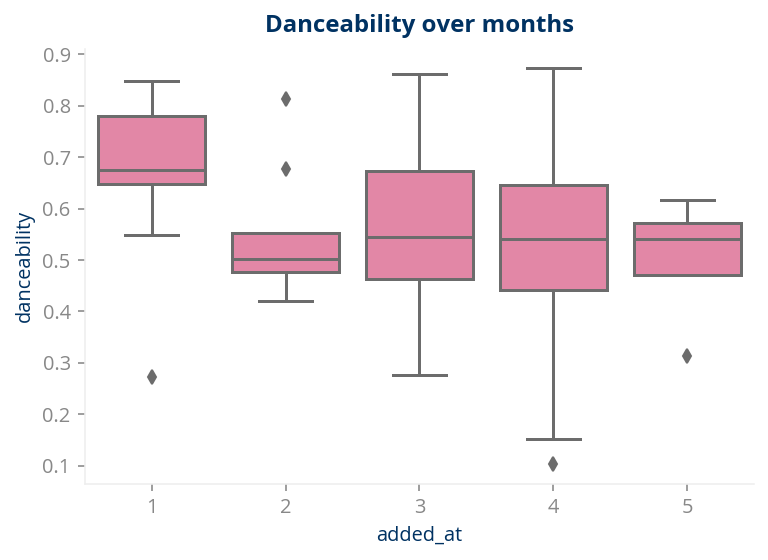

In [49]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.danceability, color='#f178a1')
plt.title("Danceability over months", fontsize=12, y=1.01,weight='bold')

plt.show()

### Energy

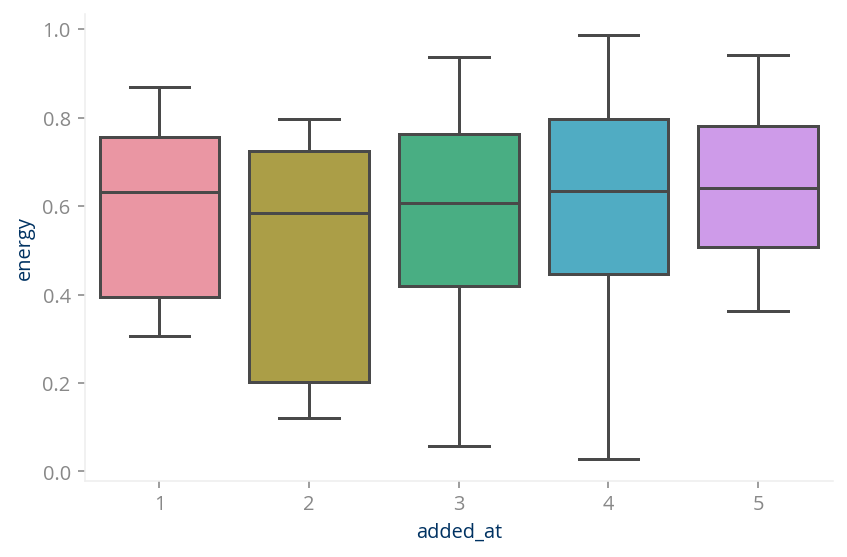

In [37]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.energy)

plt.tight_layout()

### Loudness

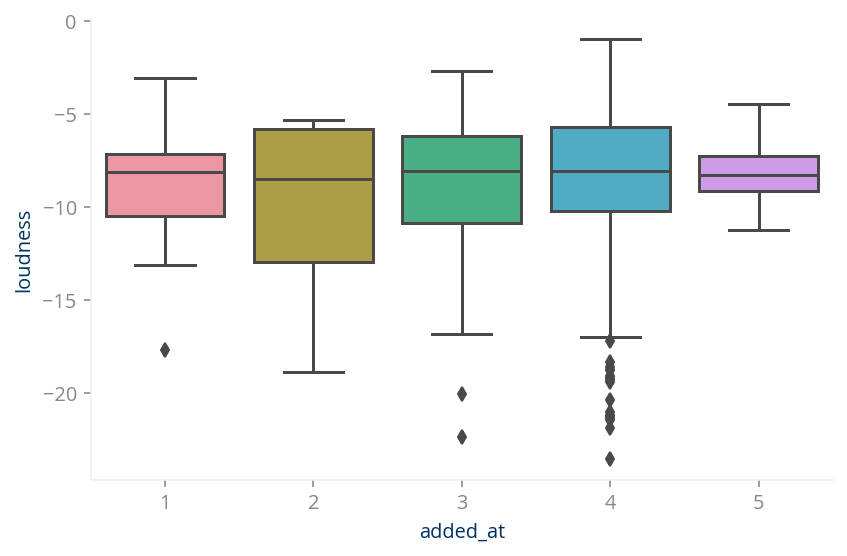

In [28]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.loudness)

plt.tight_layout()

### Acousticness

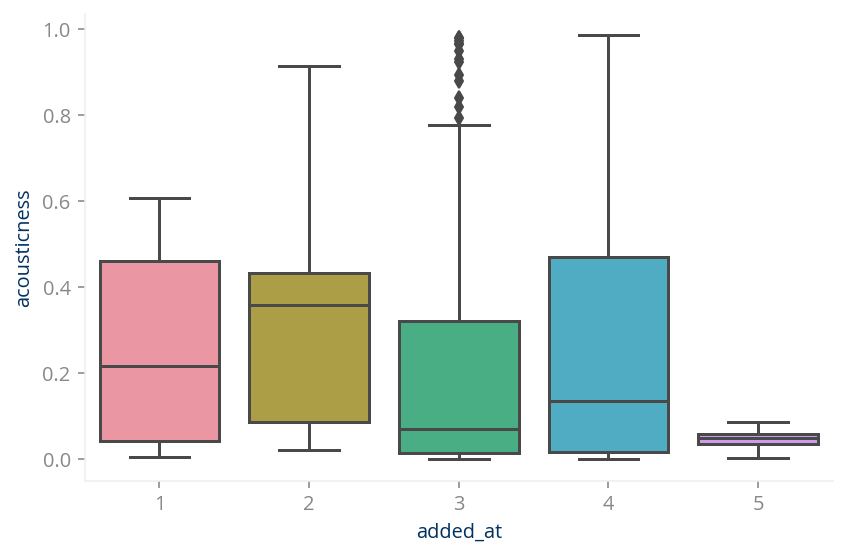

In [27]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.acousticness)

plt.tight_layout()

### Instrumentalness

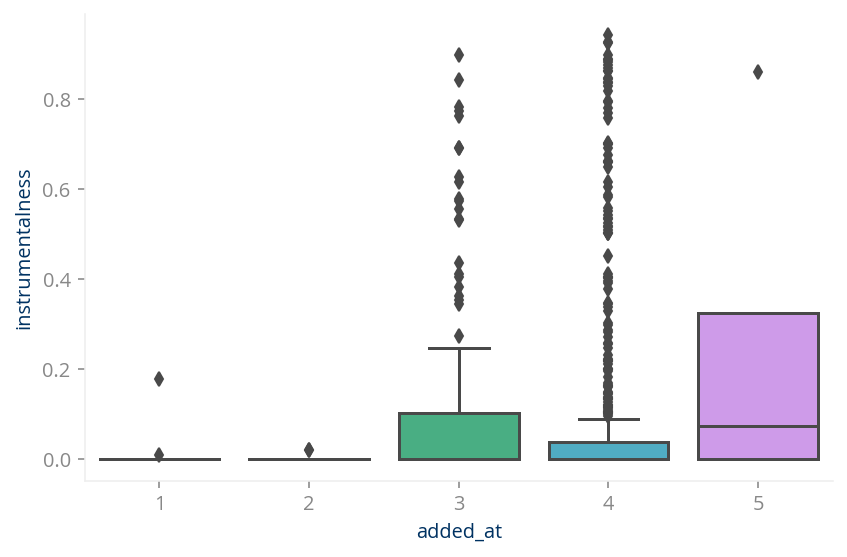

In [31]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.instrumentalness)

plt.tight_layout()

### Liveness

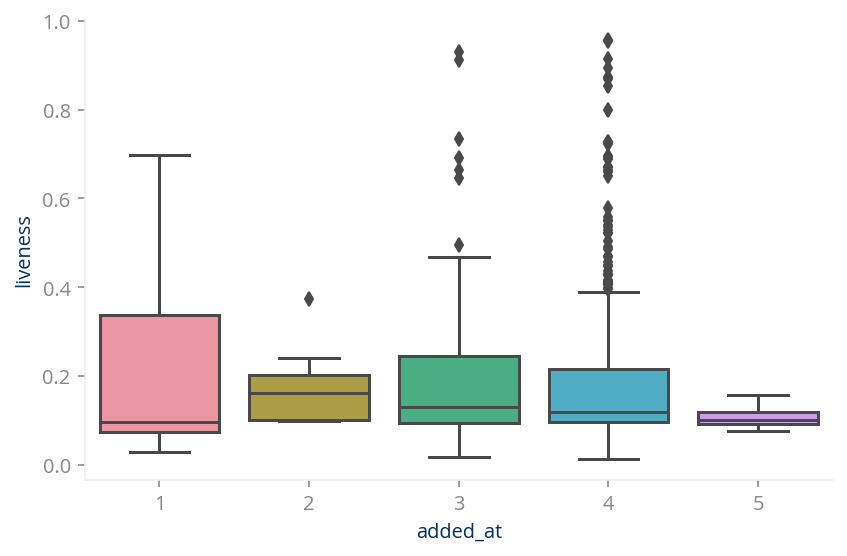

In [32]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.liveness)

plt.tight_layout()

### Speechiness

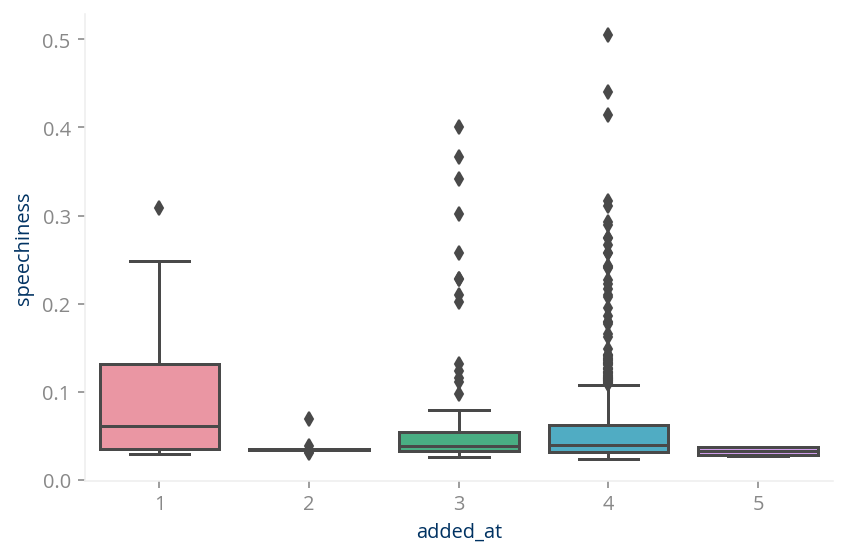

In [33]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.speechiness)

plt.tight_layout()

### Tempo

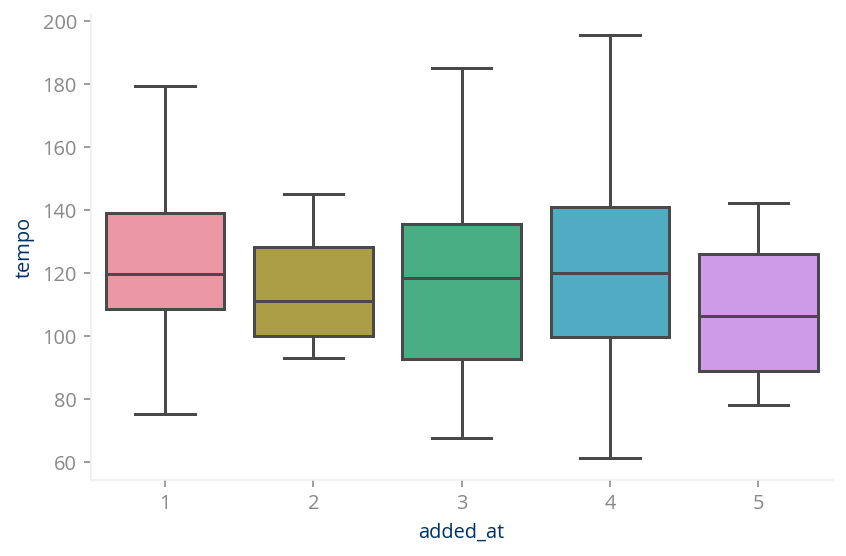

In [34]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.tempo)

plt.tight_layout()

### Valence

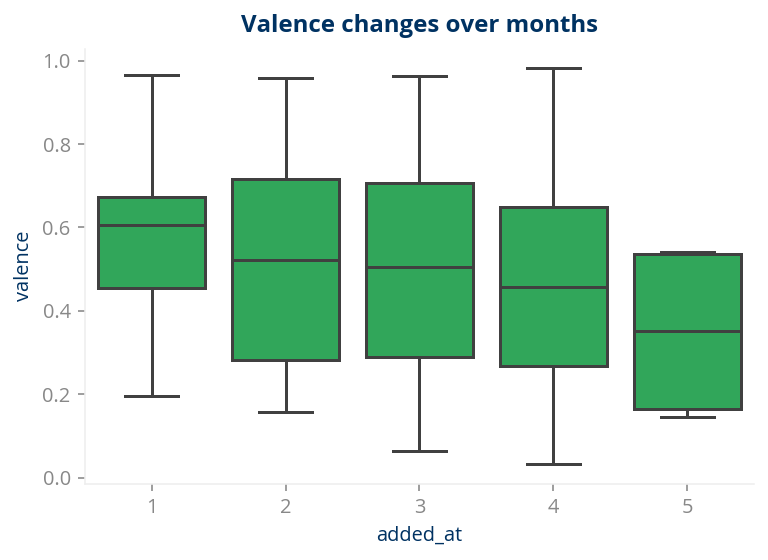

In [24]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.valence, color='#1eb954')

plt.title("Valence changes over months", fontsize=12,y=1.01,weight='bold')

plt.show()

### Seasonality x valence

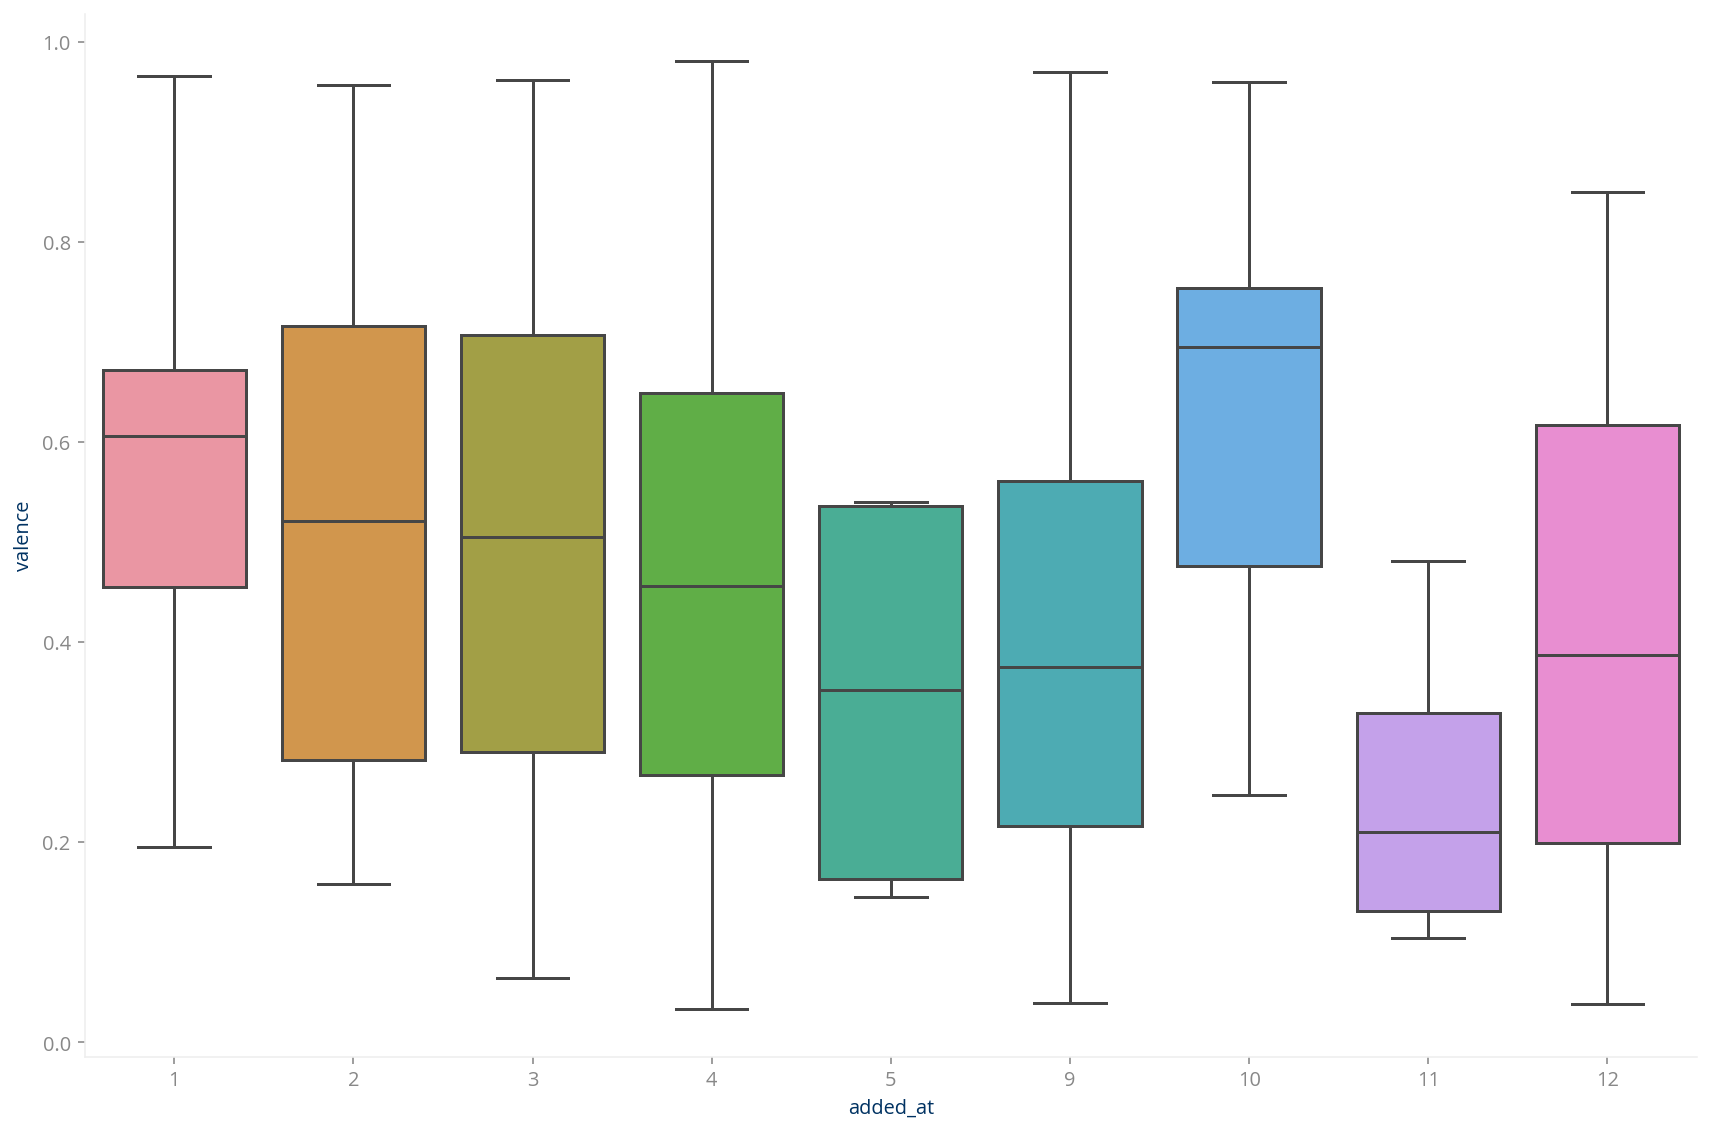

In [36]:
sns.boxplot(x=tracks_w_features.added_at.dt.month, y=tracks_w_features.valence)
plt.tight_layout()

### Seasonality x danceability

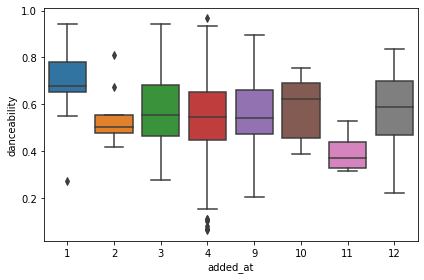

In [197]:
sns.boxplot(x=tracks_w_features.added_at.dt.month, y=tracks_w_features.danceability)
plt.tight_layout()

### Danceability x valence

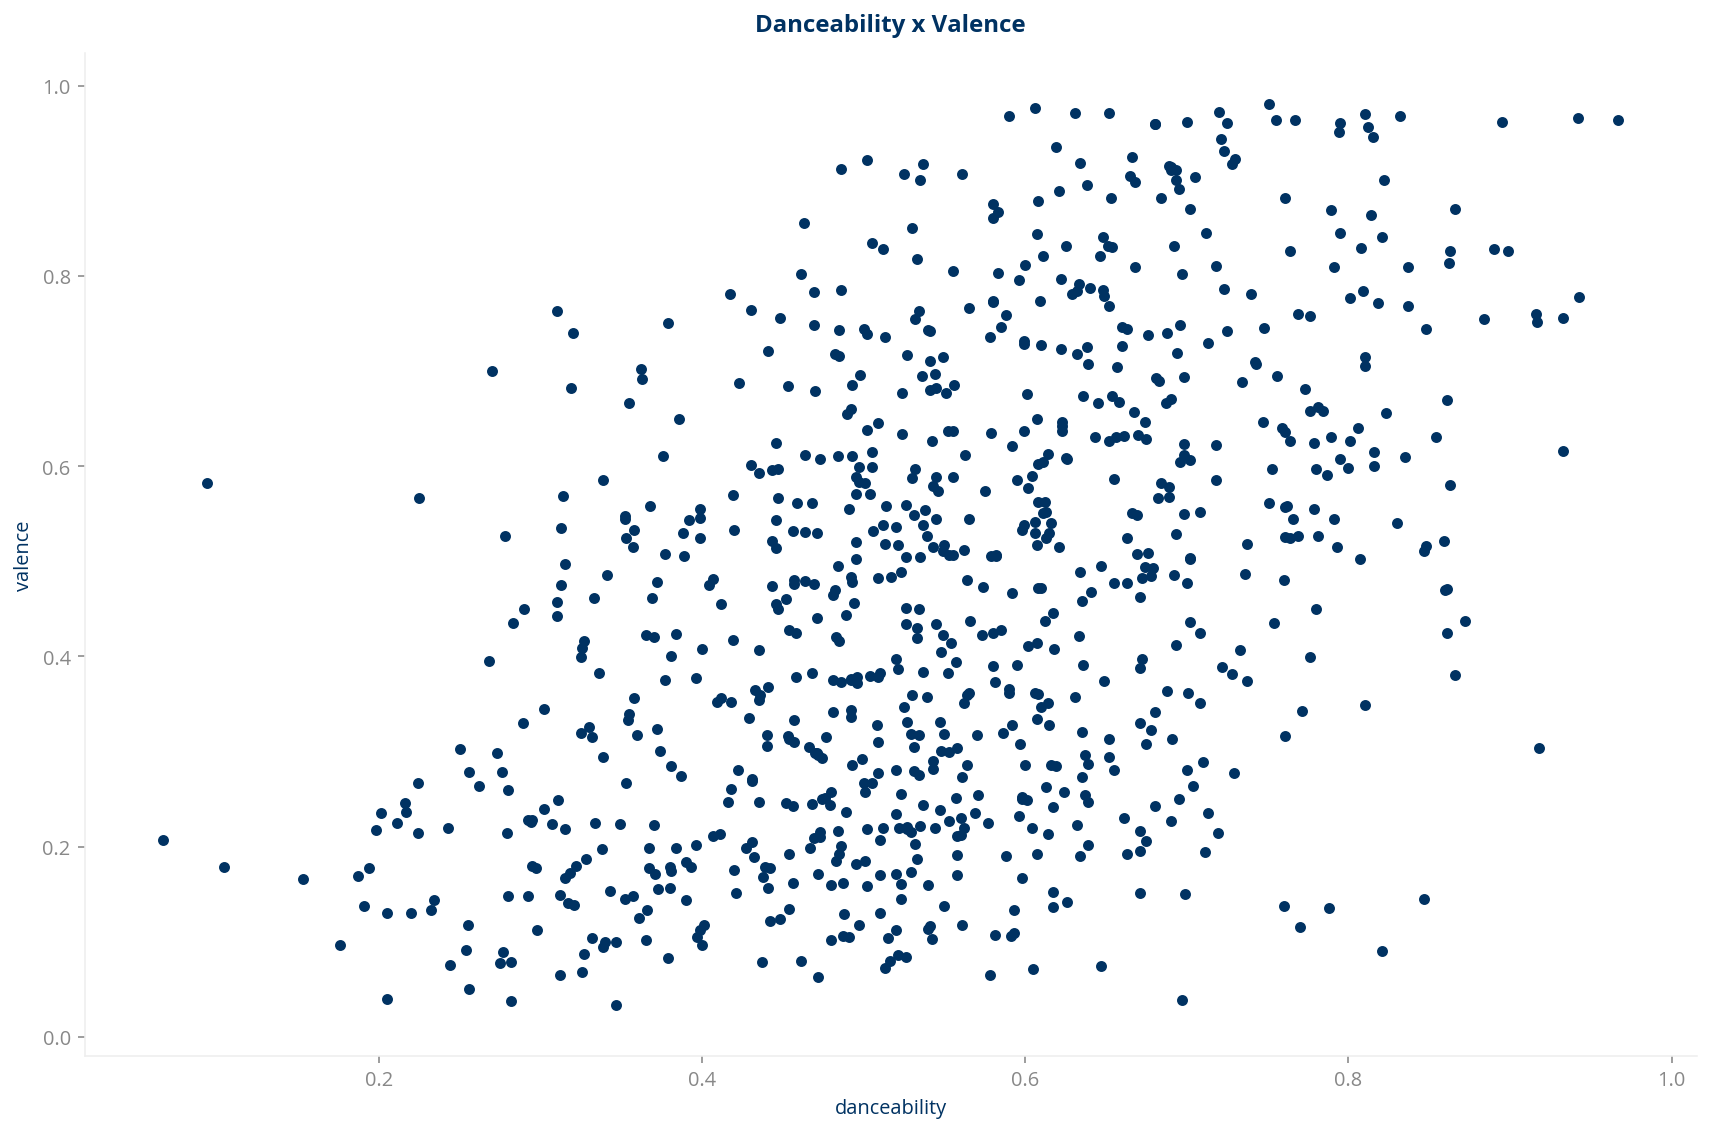

In [51]:
tracks_w_features.plot(kind='scatter', x='danceability', y='valence')
plt.title("Danceability x Valence", fontsize=12, y=1.01,weight='bold')
plt.tight_layout()

### Danceability x loudness

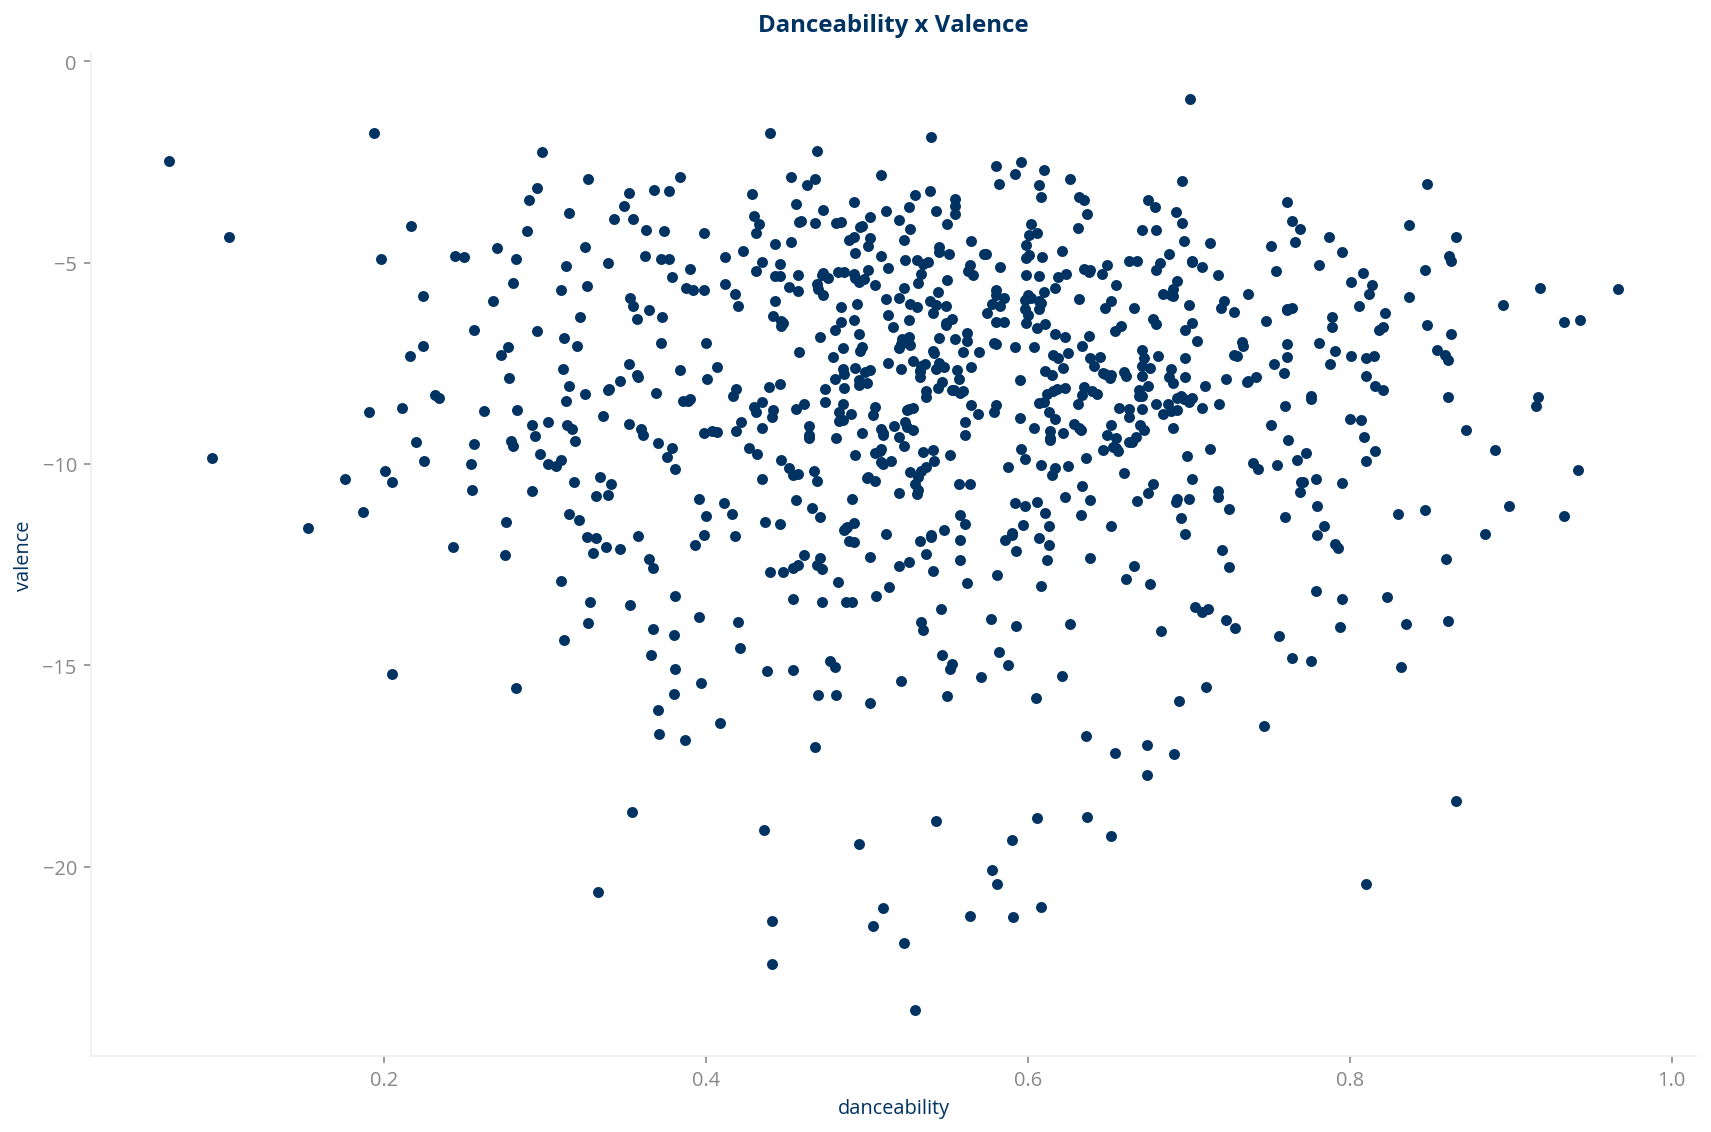

In [53]:
tracks_w_features.plot(kind='scatter', x='danceability', y='loudness')
plt.ylabel('valence')
plt.tight_layout()

### Danceability x tempo

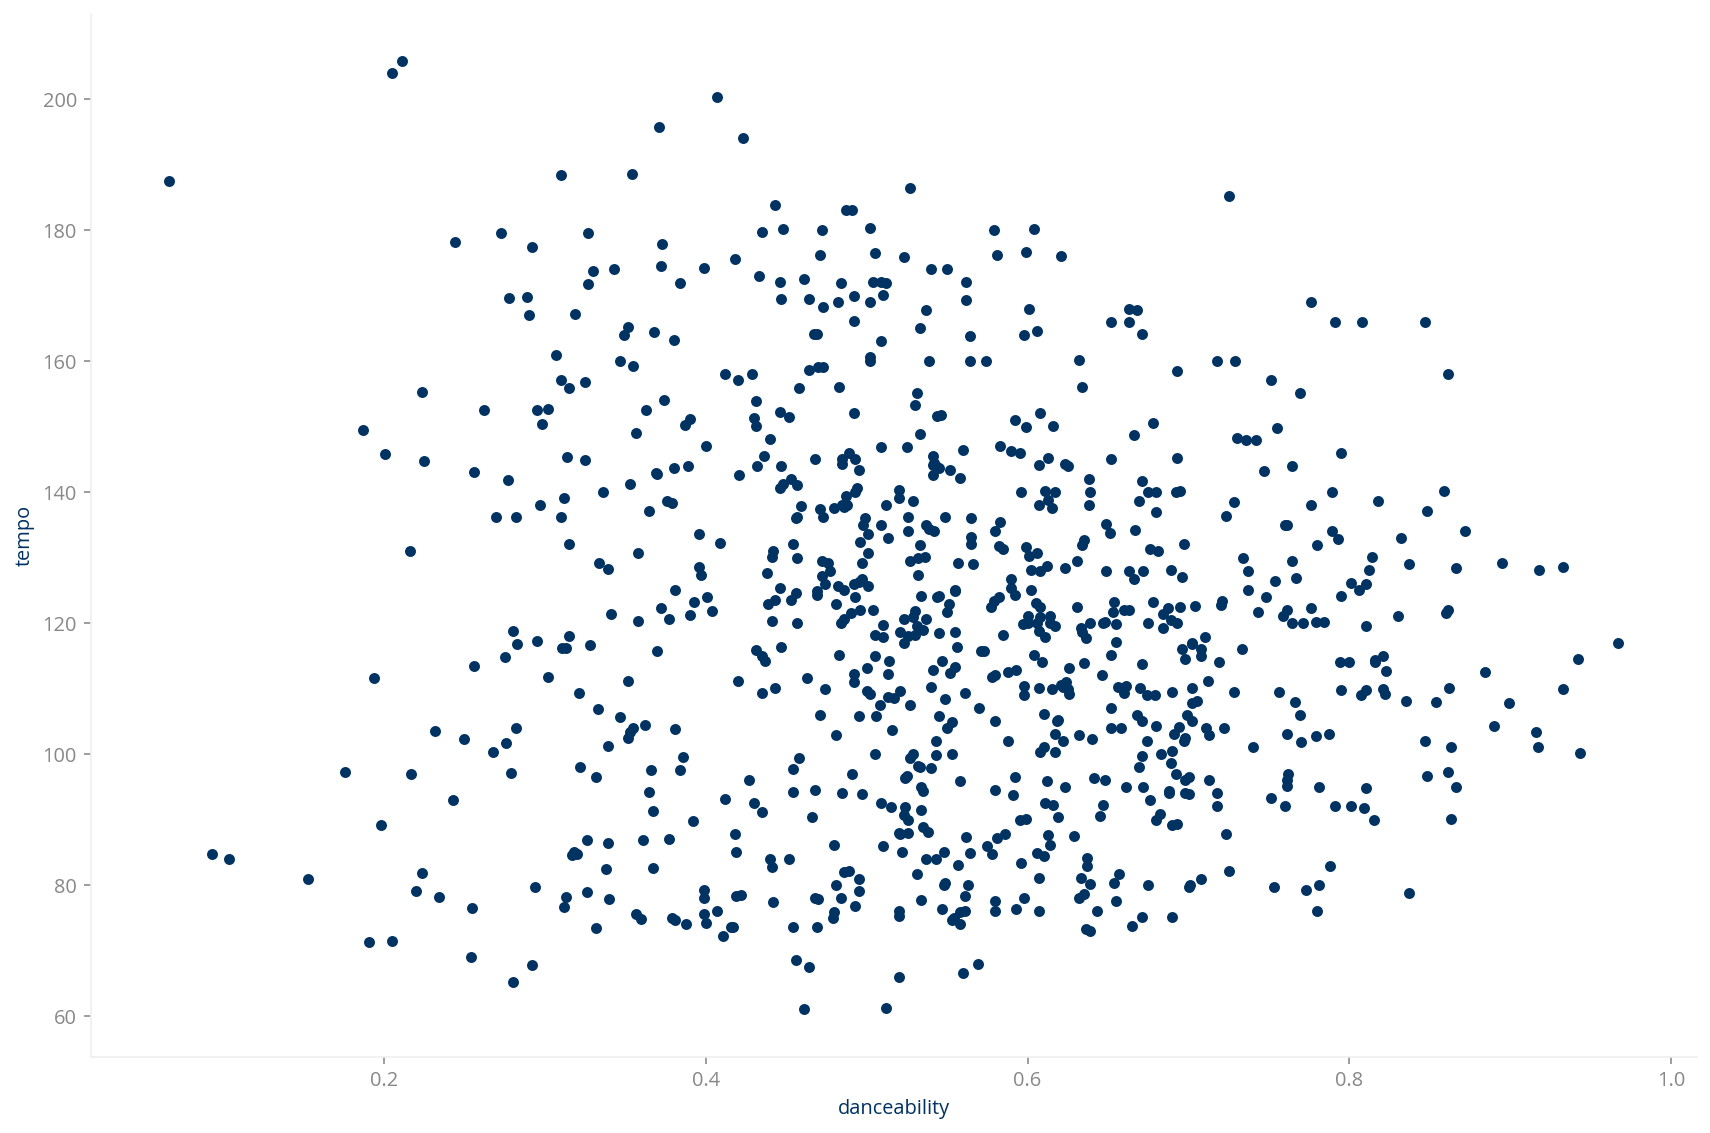

In [41]:
tracks_w_features.plot(kind='scatter', x='danceability', y='tempo')
plt.tight_layout()

### Instrumentalness x speechiness

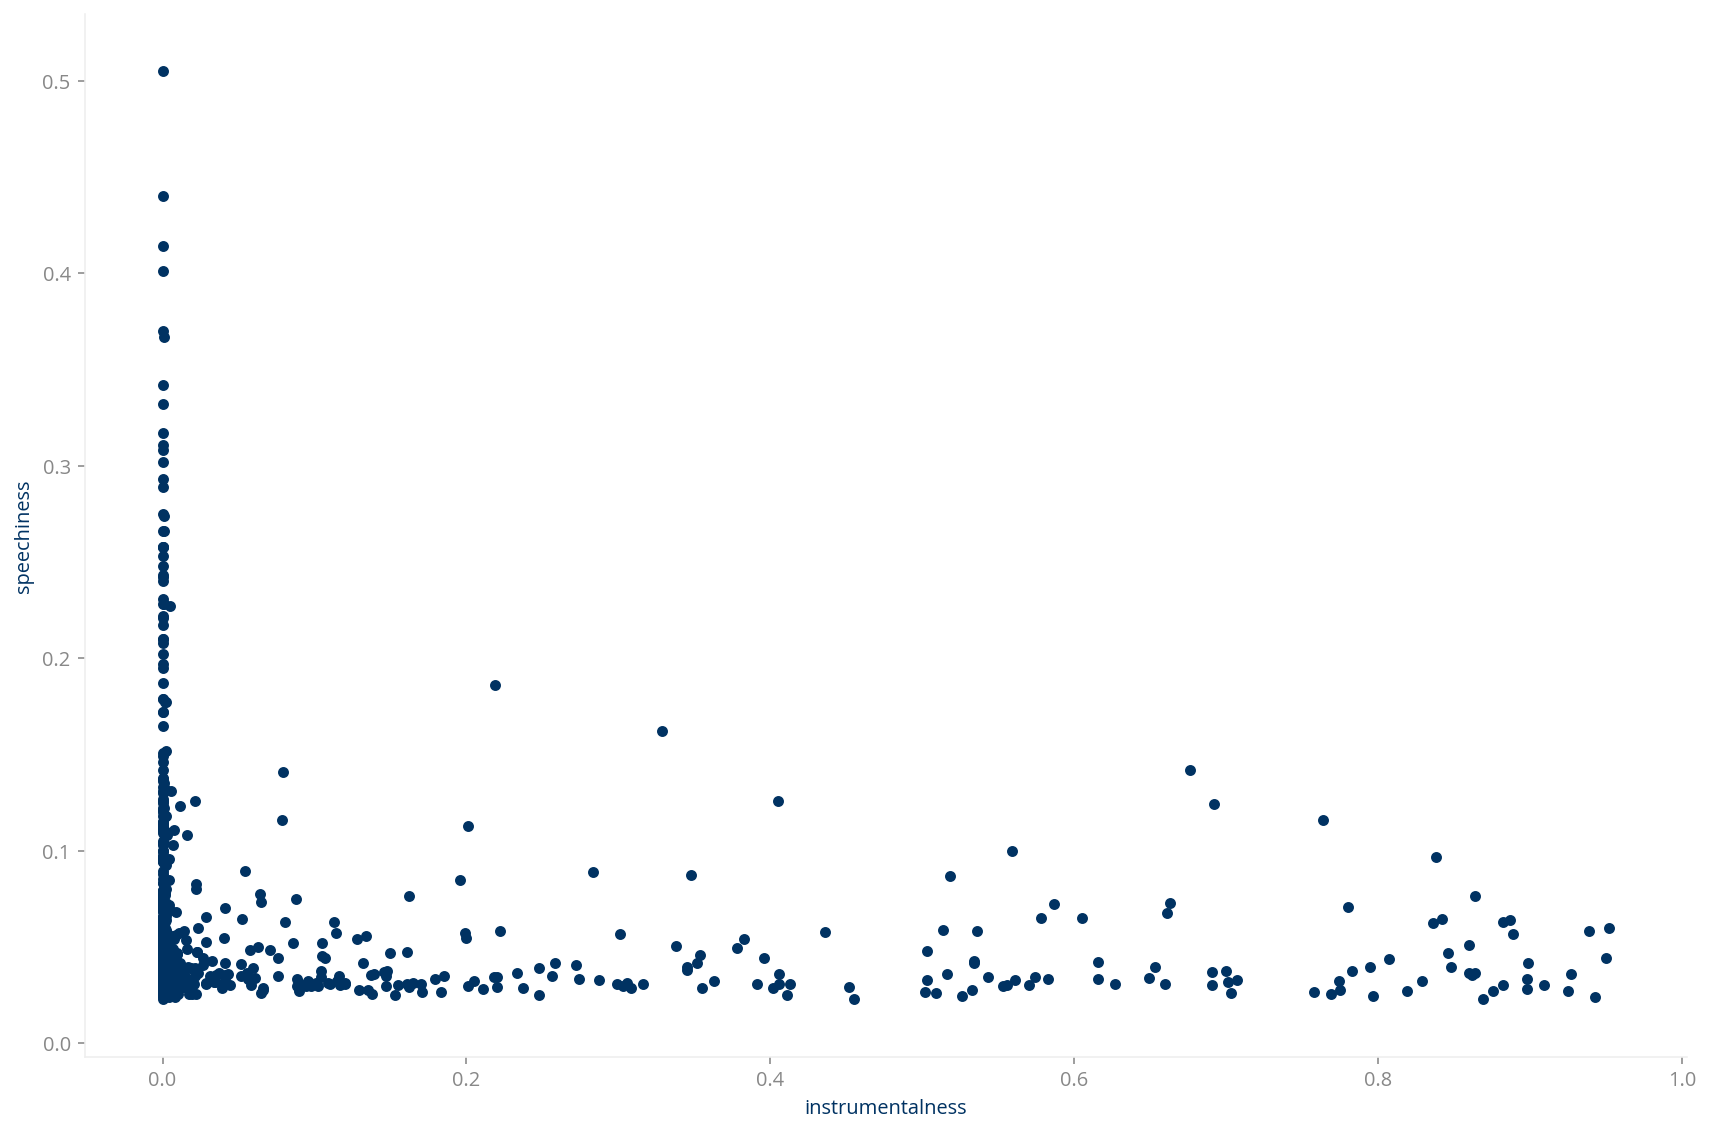

In [66]:
tracks_w_features.plot(kind='scatter', x='instrumentalness', y='speechiness')
plt.tight_layout()

## Vector distance

In [56]:
encode_fields = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
]

def encode(row):
    return np.array([
        (row[k] - tracks_w_features[k].min())
        / (tracks_w_features[k].max() - tracks_w_features[k].min())
        for k in encode_fields])

tracks_w_features_encoded = tracks_w_features.assign(
    encoded=tracks_w_features.apply(encode, axis=1))

In [57]:
tracks_w_features_encoded.head()

,id,artists,song_title,added_at,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,encoded
0,5a4MgIUSf9K8wXLSm6xPEx,Pink Floyd,High Hopes,2019-09-21 18:38:25+00:00,0.520,0.411,0,-12.536,0,0.0250,0.2020,0.153000,0.3510,0.280,75.235,510965,4,"[0.503553976010662, 0.39974989578991243, 0.0, ..."
1,7u8yddev0YnNFGkZoP8X2t,Blur,To the End - 2012 Remaster,2019-09-21 18:38:26+00:00,0.524,0.634,2,-8.968,1,0.0249,0.0166,0.000068,0.0895,0.634,96.289,244600,4,"[0.5079964460239894, 0.6321383909962485, 0.181..."
2,5g19EQEmBkiFuyTztsFjMU,Stereophonics,Indian Summer,2019-09-21 18:38:26+00:00,0.668,0.695,0,-4.961,1,0.0283,0.4050,0.000000,0.4270,0.809,105.926,267120,4,"[0.6679253665037762, 0.6957065443934972, 0.0, ..."
3,7jY2puQFxonAToK9HSnIuo,The London Suede,He's Gone,2019-09-21 18:38:26+00:00,0.211,0.692,7,-8.603,1,0.0416,0.0210,0.352000,0.6090,0.225,205.757,332753,4,"[0.1603731674811195, 0.6925802417674031, 0.636..."
4,2DPiTxkAJppAZ32M3jm6CZ,Brett Anderson,Back to You,2019-09-21 18:38:27+00:00,0.474,0.330,8,-8.127,0,0.0293,0.9360,0.000151,0.0984,0.293,125.913,194187,4,"[0.4524655708573967, 0.31533972488536893, 0.72..."


In [58]:
tracks_w_features_encoded_product = tracks_w_features_encoded.assign(temp=0) \
    .merge(tracks_w_features_encoded.assign(temp=0), on='temp', how='left').drop(columns='temp')

tracks_w_features_encoded_product = tracks_w_features_encoded_product[
    tracks_w_features_encoded_product.id_x != tracks_w_features_encoded_product.id_y]

tracks_w_features_encoded_product['merge_id'] = tracks_w_features_encoded_product \
    .apply(lambda row: ''.join(sorted([row['id_x'], row['id_y']])), axis=1)

tracks_w_features_encoded_product['distance'] = tracks_w_features_encoded_product \
    .apply(lambda row: np.linalg.norm(row['encoded_x'] - row['encoded_y']), axis=1)

### The most similar songs

In [59]:
tracks_w_features_encoded_product \
    .sort_values('distance') \
    .drop_duplicates('merge_id') \
    [['artists_x', 'song_title_x', 'artists_y', 'song_title_y', 'distance']].head(10)

,artists_x,song_title_x,artists_y,song_title_y,distance
517433,Florence + The Machine,The End Of Love,Glass Animals,Gooey,0.011732
692603,The Stone Roses,Love Spreads,The Stone Roses,Love Spreads,0.038285
535333,OK Go,Here It Goes Again,The Jesus and Mary Chain,Some Candy Talking,0.108457
553725,The Libertines,Can't Stand Me Now,Foo Fighters,Monkey Wrench,0.117521
215203,AC/DC,Thunderstruck,Muse,Starlight,0.141387
382428,Marilyn Manson,The Nobodies,Foo Fighters,My Hero,0.147820
139628,Pulp,Something Changed,Ween,Mutilated Lips,0.158513
140656,Blur,My Terracotta Heart,Men I Trust,Tailwhip,0.161328
166935,Talking Heads,Road to Nowhere,HAIM,The Steps,0.162264
285642,Halestorm,Bad Romance,Dodgy,Good Enough,0.162886


### The most different songs

In [60]:
tracks_w_features_encoded_product.sort_values('distance', ascending=False) \
    .drop_duplicates('merge_id') \
    [['artists_x', 'song_title_x', 'artists_y', 'song_title_y', 'distance']] \
    .head(10)

,artists_x,song_title_x,artists_y,song_title_y,distance
14537,"Skrillex,The Doors,Ray Manzarek,Robby Krieger",Breakn' a Sweat,Per-Olov Kindgren,After Silence,2.274877
559745,Muse,Psycho,Piano Dreamers,Heaven's Gate,2.262105
55834,Piano Dreamers,Heaven's Gate,Dodgy,Good Enough,2.247200
259553,Iggy Pop,The Passenger,Piano Dreamers,Heaven's Gate,2.240898
103289,Per-Olov Kindgren,After Silence,Oasis,Slide Away,2.240454
421521,Marilyn Manson,Third Day of a Seven Day Binge,Piano Dreamers,Heaven's Gate,2.240242
103430,Per-Olov Kindgren,After Silence,Tenacious D,Tribute - Live,2.239977
103446,Per-Olov Kindgren,After Silence,Halestorm,I Am the Fire,2.236150
183387,Lera Lynn,My Least Favorite Life - From The HBO Series T...,The Cure,Close to Me - Remastered,2.232612
712441,Halestorm,I Hate Myself For Loving You,Per-Olov Kindgren,After Silence,2.231331


### The most average songs

In [61]:
tracks_w_features_encoded_product \
    .groupby(['artists_x', 'song_title_x']) \
    .sum()['distance'] \
    .reset_index() \
    .sort_values('distance') \
    .head(10)

,artists_x,song_title_x,distance
687,The Animals,We Gotta Get Out Of This Place - UK Single Ver...,792.456103
688,The Band Perry,If I Die Young,795.395919
33,Arctic Monkeys,Do I Wanna Know?,800.080899
484,One Direction,Story of My Life,806.112498
810,Urge Overkill,"Girl, You'll Be a Woman Soon",809.318598
263,Guns N' Roses,Knockin' On Heaven's Door,817.417034
834,alt-J,Tessellate,819.300630
830,alt-J,Breezeblocks,819.582849
170,Divinyls,I Touch Myself,822.570125
673,"Tears For Fears,Dave Bascombe","Head Over Heels - Dave Bascombe 7"" N.Mix",824.517253


### The most outstanding songs

In [65]:
tracks_w_features_encoded_product \
    .groupby(['artists_x', 'song_title_x']) \
    .sum()['distance'] \
    .reset_index() \
    .sort_values('distance', ascending=False) \
    .head(10)

,artists_x,song_title_x,distance
776,The Stone Roses,Love Spreads,1859.548582
504,Piano Dreamers,Heaven's Gate,1504.676314
493,Per-Olov Kindgren,After Silence,1406.159590
494,Per-Olov Kindgren,I Miss You,1354.525644
406,Men I Trust,All Night,1348.317181
384,MONO,Ashes in the Snow - Remastered,1324.674595
651,Sufjan Stevens,Fourth of July,1302.830370
815,Wang Wen,Daybreak,1297.613083
297,Immortal Technique,Dance with the Devil,1282.210310
365,Lera Lynn,My Least Favorite Life - From The HBO Series T...,1277.678153


### The most average artists

In [63]:
tracks_w_features_encoded_product \
    .groupby(['artists_x']) \
    .mean()['distance'] \
    .reset_index() \
    .sort_values('distance') \
    .head(10)

,artists_x,distance
316,The Band Perry,0.939074
234,One Direction,0.951727
375,Urge Overkill,0.955512
76,Divinyls,0.971157
311,"Tears For Fears,Dave Bascombe",0.973456
334,The Good Life,0.974541
257,"Queen,David Bowie",0.975593
258,Quinn Lewis,0.979994
243,"Peter Malick,Norah Jones",0.980938
283,"Skrillex,Ellie Goulding",0.981191


### The most outstanding artists

In [64]:
tracks_w_features_encoded_product \
    .groupby(['artists_x']) \
    .mean()['distance'] \
    .reset_index() \
    .sort_values('distance', ascending=False) \
    .head(10)

,artists_x,distance
248,Piano Dreamers,1.776477
241,Per-Olov Kindgren,1.629684
190,MONO,1.563961
379,Wang Wen,1.532011
132,Immortal Technique,1.513826
287,Snarky Puppy,1.487044
365,Thom Yorke,1.477196
140,Japan,1.474369
200,Mark Sandman,1.473015
114,"Gorillaz,Mavis Staples,Pusha T",1.470189
